# Dataset exploration and cleaning


In this notebook, we will:
1. **Visualize the dataset**: Gain insights into the types and distribution of images.
2. **Identify and remove outliers**: Eliminate data anomalies that could affect model performance.
3. **Handle duplicate images**: Ensure each image in the dataset is unique to avoid data leakage during training.

These steps are crucial for improving the model's robustness and accuracy by providing clean and meaningful data.


In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import random

# Loading the data
data = np.load('data/training_set.npz', allow_pickle=True)

# Dividing data
labels = data['labels']
images = data['images']

## Visualizing the Dataset


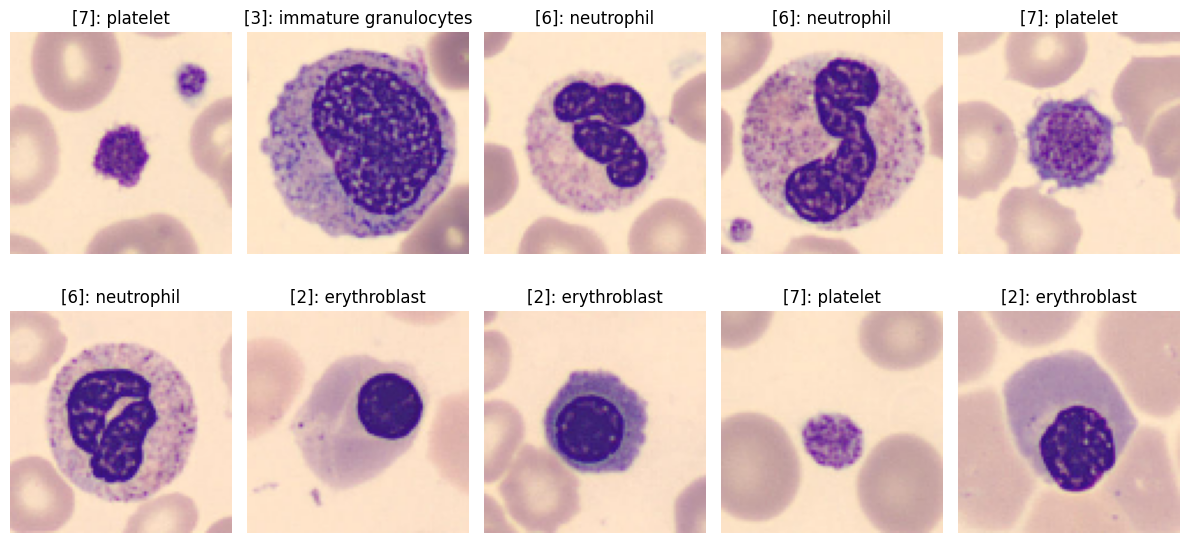

In [2]:
def visualize_sample_images(images, labels, class_names, num_samples=10): 
    """ 
    Visualizes a grid of sample images from the dataset. 
    """ 
    plt.figure(figsize=(12, 6)) 
    for i in range(num_samples): 
        ax = plt.subplot(2, 5, i + 1) 
        plt.imshow(images[i]) 
        plt.title(f"{labels[i]}: {class_names[int(labels[i].item())]}") 
        plt.axis("off") 
    plt.tight_layout() 
    plt.show() 
     
class_names = ["basophil", "eosinophil", "erythroblast", "immature granulocytes", 
               "lymphocyte", "monocyte", "neutrophil", "platelet"]
visualize_sample_images(images, labels, class_names)

## Removing Outliers from the Dataset
Outliers are images that either do not belong to any of the expected classes or are duplicates.
In our dataset, we identified two specific outlier images that were duplicated, distorted, and assigned to multiple classes.

To address this issue:

- We located one representative index for each outlier image.
- We removed all images similar to these outliers within a specified tolerance (0.0001).
This approach ensures that even slightly altered versions of the outlier images, such as those with minor distortions or variations, are also removed.

In addition, we identified pairs of identical images across almost every class and removed these duplicates to ensure that each image in the dataset is unique.

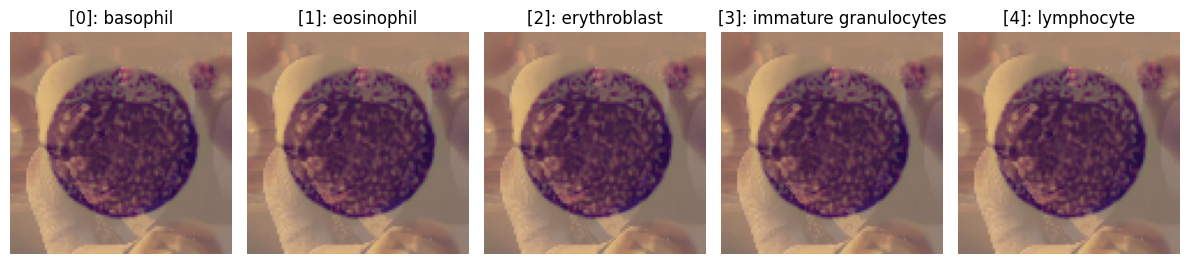

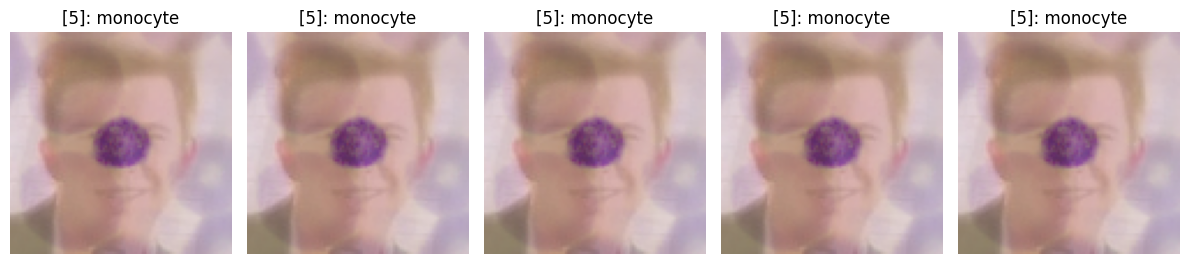

In [3]:
# Visualize outliers
def visualize_images(images, labels, class_names, num_samples=5, start_type='shrek', starting_index=0):
   """
   Visualizes a grid of sample images from the dataset.
   
   Args:
   - start_type: 'shrek' for jumping 200 images, 'troll' for consecutive images
   """
   plt.figure(figsize=(12, 6))
   
   if start_type == 'shrek':
       indices = [i * 200 + starting_index for i in range(num_samples)]
   else:  # 'troll'
       indices = list(range(starting_index, starting_index + num_samples))
   
   for j, i in enumerate(indices, 1):
       ax = plt.subplot(2, 5, j)
       plt.imshow(images[i])
       plt.title(f"{labels[i]}: {class_names[int(labels[i].item())]}") 
       plt.axis("off")
   
   plt.tight_layout()
   plt.show()

class_names = ["basophil", "eosinophil", "erythroblast", "immature granulocytes",
               "lymphocyte", "monocyte", "neutrophil", "platelet"]
visualize_images(images, labels, class_names, start_type='shrek', starting_index=11959)
visualize_images(images, labels, class_names, start_type='troll', starting_index=13559)

In [4]:
# Function to check if an image matches the conditions
def check_image(i, img, shrek, troll, tol):
    """Check if an image matches the shrek or troll images within a tolerance."""
    if (np.allclose(img, shrek, atol=tol) or np.allclose(img, troll, atol=tol)):
        return i
    return None

# Function to parallelize the process of finding the indices to remove
def parallel_index_removal(data, shrek, troll, tol=0.0001, num_workers=4):
    """Parallelize the removal of images that match 'shrek' or 'troll'."""
    with Pool(processes=num_workers) as pool:
        results = pool.starmap(check_image, [(i, img, shrek, troll, tol) for i, img in enumerate(data)])

    # Filter out None values (no matches) and return the indices to remove
    index_to_remove = [index for index in results if index is not None]
    
    return index_to_remove

# Function to clean the dataset
def clean_dataset(images, labels):
    """
    Cleans the dataset by removing outliers and duplicate images.
    """
    # Define Shrek and Troll images
    shrek = images[11959]
    troll = images[13559]

    # Find indices of Shrek and Troll images to remove
    index_to_remove = parallel_index_removal(images, shrek, troll, tol=0.0001, num_workers=4)

    # Identify indices of non-unique images to remove
    _, unique_indices = np.unique(images, axis=0, return_index=True)
    all_indices = np.arange(len(images))
    duplicate_indices = np.setdiff1d(all_indices, unique_indices)

    # Combine duplicate indices with the Shrek and Troll indices
    index_to_remove = np.unique(np.concatenate((index_to_remove, duplicate_indices)))

    # Remove the images and labels at those indices
    images = np.delete(images, index_to_remove, axis=0)
    labels = np.delete(labels, index_to_remove)

    print(f"Removed {len(index_to_remove)} duplicate and unwanted images.")

    # Return the modified images and labels
    return images, labels

print(f"Dataset size before cleaning: {len(images)}")

images, labels = clean_dataset(images, labels)

print(f"Dataset size after cleaning: {len(images)}")

# Save the cleaned dataset
np.savez_compressed('data/training_set_clean.npz', images=images, labels=labels)

Dataset size before cleaning: 13759
Removed 1808 duplicate and unwanted images.
Dataset size after cleaning: 11951


## Visualize cleaned dataset

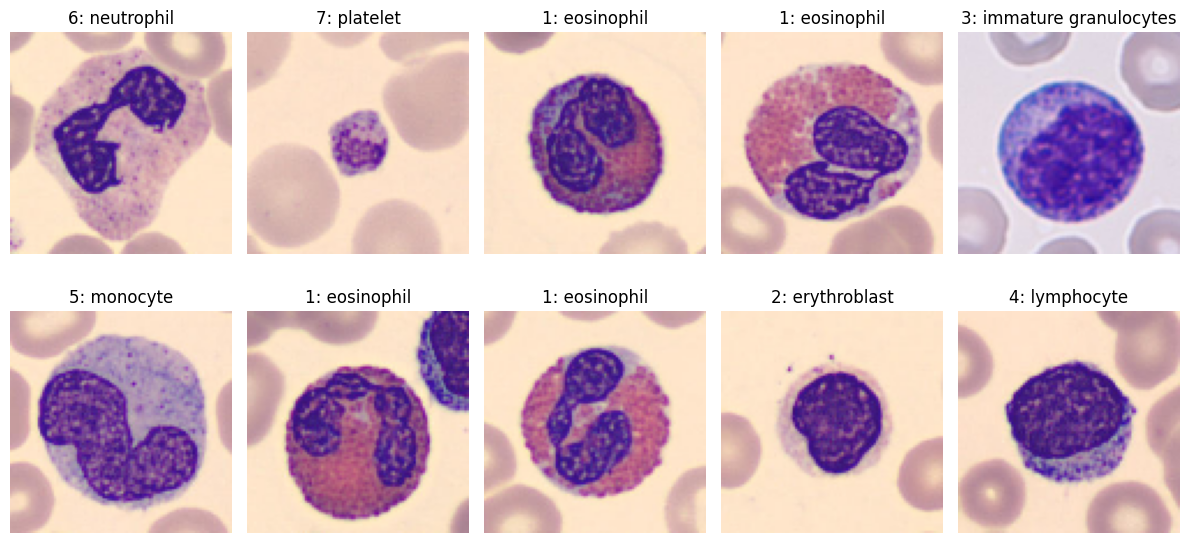

In [5]:
# Visualize the cleaned dataset
def visualize_random_images(images, labels, class_names, num_samples=10):
    """ 
    Visualizes a grid of random sample images from the dataset. 
    """ 
    plt.figure(figsize=(12, 6)) 
    random_indices = random.sample(range(len(images)), num_samples)
    for i, idx in enumerate(random_indices): 
        ax = plt.subplot(2, 5, i + 1) 
        plt.imshow(images[idx]) 
        plt.title(f"{labels[idx]}: {class_names[int(labels[idx].item())]}") 
        plt.axis("off") 
    plt.tight_layout() 
    plt.show() 

visualize_random_images(images, labels, class_names)